In [1]:
from itertools import product
import random

In [2]:
import numpy as np
from matplotlib import pyplot as plt

(0, 0, 0, 0) A
(0, 0, 0, 1) A
(0, 0, 1, 0) A
(0, 0, 1, 1) A
(0, 1, 0, 0) A
(0, 1, 0, 1) A
(0, 1, 1, 0) A
(0, 1, 1, 1) A
(1, 0, 0, 0) B
(1, 0, 0, 1) B
(1, 0, 1, 0) B
(1, 0, 1, 1) B
(1, 1, 0, 0) B
(1, 1, 0, 1) B
(1, 1, 1, 0) B
(1, 1, 1, 1) B


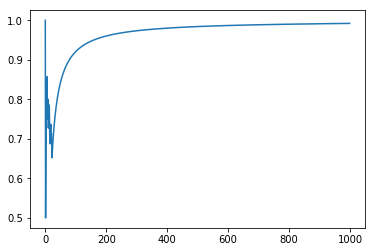

In [3]:
from COVIS_R_based_explicit import RuleBasedSystem;
from COVIS_procedural_system import ProceduralLearningSystem;

In [4]:
class COVIS(object):
    """
    COVIS has two subsystems: (E)xplicit and (P)rocedural. At each stimulus presentation, COVIS 
    feeds the stimulus to both subsystems and then decides whose prediction to use based on two 
    parameters:
    1. Theta - trust in a given subsystem based on its success history
    2. h - confidence of a given sybsystem in its prediction
    """
    
    def __init__(self, delta_OC, delta_OE, rule_based_params, procedural_params):
        self.delta_OC = delta_OC
        self.delta_OE = delta_OE
        self.rule_based_system = RuleBasedSystem(**rule_based_params)
        self.procedural_system = ProceduralLearningSystem(**procedural_params)
        
        # Initial values for trust (p. 77)
        self.Theta_E = 0.99
        self.Theta_P = 0.01
        
        self.current_prediction_E = None
        self.current_prediction_P = None
        self.current_winner = None
        
    def _feed_stimulus_to_a_system(self, stimulus, system, real_categ):
        """
        Returns (confidence, prediction) of system
        """
        system.process_stimulus(stimulus, real_categ)
        return system.confidence_in_prediction, system.current_prediction
        
    def process_stimulus(self, stimulus, real_categ):
        
        # h_* - absolute value of the normalized discriminant value, not the original value (see p. 76)
        h_E, self.current_prediction_E = self._feed_stimulus_to_a_system(
            stimulus, self.rule_based_system, real_categ)
        h_P, self.current_prediction_P = self._feed_stimulus_to_a_system(
            stimulus, self.procedural_system, real_categ)
        
        # Select whose prediction to use (p. 77)
        if h_E * self.Theta_E > h_P * self.Theta_P:
            self.current_prediction = self.current_prediction_E
            self.predicted_by = self.rule_based_system
        else:
            self.current_prediction = self.current_prediction_P
            self.predicted_by = self.rule_based_system
            
        
        self.process_feedback(real_categ)
        is_correct = self.current_prediction == real_categ
        return is_correct
            
    def process_feedback(self, feedback):
        """
        Updates the trust values
        """
        if self.current_prediction_E == feedback:
            self.Theta_E += self.delta_OC * (1 - self.Theta_E)  # p. 77, Eq. (15)
        else:
            self.Theta_E -= self.delta_OE * self.Theta_E  # p. 77, Eq. (16)
            
        self.Theta_P = 1 - self.Theta_E  # p. 77, paragraph after Eq. (16)        
        
    

# Test

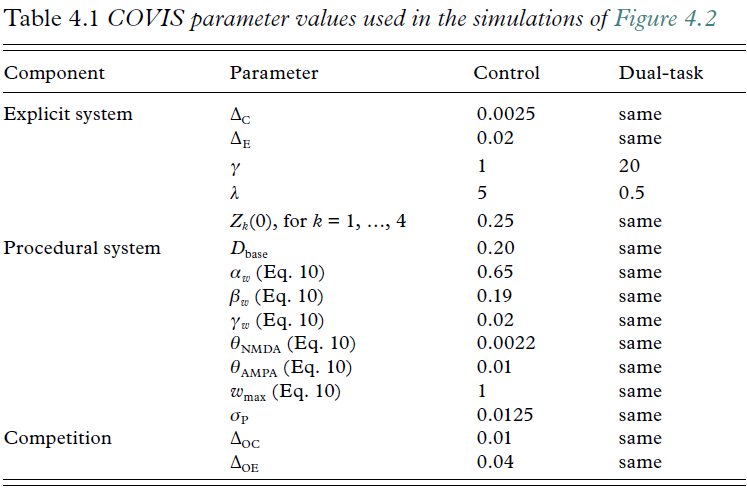

## Rule-based

In [5]:
rbs = RuleBasedSystem(n_dims=4, sigma_e_2=0.0, gamma=1.0, lambda_=5.0, delta_C=0.0025, 
                      delta_E=0.02, delta_criterion=0.05)

In [6]:
from itertools import product
stimuli = list(product((0, 1), repeat=4))

rb_categs = ["B" if stim[0] == 1 else "A" for stim in stimuli]

for stimulus, category in zip(stimuli, rb_categs):
    print(stimulus, category)

(0, 0, 0, 0) A
(0, 0, 0, 1) A
(0, 0, 1, 0) A
(0, 0, 1, 1) A
(0, 1, 0, 0) A
(0, 1, 0, 1) A
(0, 1, 1, 0) A
(0, 1, 1, 1) A
(1, 0, 0, 0) B
(1, 0, 0, 1) B
(1, 0, 1, 0) B
(1, 0, 1, 1) B
(1, 1, 0, 0) B
(1, 1, 0, 1) B
(1, 1, 1, 0) B
(1, 1, 1, 1) B


In [7]:
np.random.seed(5678590)

results = list()

def present_the_stimuli():
    for _ in range(500):
        stimulus_ind = np.random.randint(8)
        stimulus = stimuli[stimulus_ind]
        feedback = rb_categs[stimulus_ind]
        rbs.process_stimulus(stimulus)
        results.append(rbs.process_feedback(feedback))
        
present_the_stimuli()

In [8]:
[rule.c for rule in rbs.rules]

[0.5, 1.0000000000000004, 1.0000000000000004, 1.0000000000000004]

The onle relevant rule - rule 1 - did not change its criterion. This makes sense because without noise it is always correct.

Criteria of all the other rules went just above $1$ which makes the discriminant value less than $0$ for all the sitmuli. Since we have zero noise it means these rules always choose category "A". This makes no sense since for any criterion the chances of an irrelevant rule to be correct are always 50/50. There should not be a bias towards category "A".

In [9]:
[rule.salience for rule in rbs.rules]

[0.5799999999999985,
 0.4975000000000003,
 0.4600000000000003,
 0.5324999999999995]

These saliences don't makes sense at the first glance. One would expect the salience of the first rule to be large while the others should have plummeted. Maybe the reason this is not so is that the irrelevant rules are rarely chosen and thus their salience do not get updated much. Let's see if presenting the stimuli again would only lead to the changes in the salience of the first rule.

In [10]:
present_the_stimuli()
[rule.salience for rule in rbs.rules]

[0.9499999999999906, 0.8124999999999936, 0.749999999999995, 0.8074999999999937]

No, this is something else. The other rules do get selected and they are correct more often than not (the penalty for an error is larger than the increase in salience when the prediciton is correct, delta_E > delta_C). At the second glance, this does not make sense either.

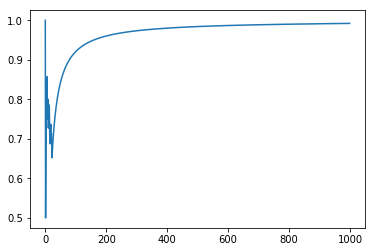

In [11]:
plt.plot(np.cumsum(results) / (np.arange(len(results)) + 1))

## Procedural

In [12]:
stimuli = list(product((0, 1), repeat=4))
n_stim = len(stimuli)

rb_categs = ["B" if stim[0] == 1 else "A" for stim in stimuli]

ii_categs = ["B" if sum(stim[:3]) > 1.5 else "A" for stim in stimuli]

In [13]:
n_blocks = 20

pl_system = ProceduralLearningSystem(inp_preferred_stimuli=np.array(stimuli), input_scale=0.01,
                                     categs=("A", "B"), sigma_striatal=0.0125,
                                     theta_nmda=0.0022, theta_ampa=0.01, d_base=0.2,
                                     alpha=0.65, beta=0.19, gamma=0.02,
                                     w_max=1.0)

blocks_ii = []
for _iter in range(n_blocks):
    block_hits = []
    for ind in random.sample(range(n_stim), n_stim):
        block_hits.append(pl_system.process_stimulus(stimuli[ind], ii_categs[ind]))
    blocks_ii.append(sum(block_hits) / float(n_stim))

In [14]:
pl_system = ProceduralLearningSystem(inp_preferred_stimuli=np.array(stimuli), input_scale=0.01,
                                     categs=("A", "B"), sigma_striatal=0.0125,
                                     theta_nmda=0.0022, theta_ampa=0.01, d_base=0.2,
                                     alpha=0.65, beta=0.19, gamma=0.02,
                                     w_max=1.0)

blocks_rb = []
for _iter in range(n_blocks):
    block_hits = []
    for ind in random.sample(range(n_stim), n_stim):
        block_hits.append(pl_system.process_stimulus(stimuli[ind], rb_categs[ind]))
    blocks_rb.append(sum(block_hits) / float(n_stim))

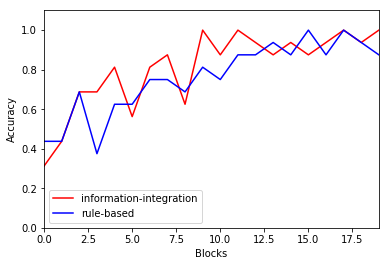

In [15]:
plt.plot(blocks_ii, 'r', label='information-integration')
plt.plot(blocks_rb, 'b', label='rule-based')

plt.xlabel('Blocks')
plt.ylabel('Accuracy')

plt.axis([0, n_blocks - 1, 0, 1.1])
plt.legend()

plt.show()

In [16]:
print("prev_pred_r:", pl_system.prev_pred_r)
print("prev_obt_r:", pl_system.prev_obt_r)
print("\nWeights:\n", pl_system.weights)

prev_pred_r: 0.8269868759015861
prev_obt_r: 1.0

Weights:
 [[0.79939877 0.41288965]
 [0.39477569 0.00933835]
 [0.48649438 0.2620326 ]
 [0.37935246 0.19021638]
 [0.88897715 0.1681117 ]
 [0.32127648 0.07672057]
 [0.18113179 0.02711115]
 [0.33519657 0.10025167]
 [0.00451831 0.03626797]
 [0.23061168 0.44520771]
 [0.34358761 0.81061949]
 [0.06019517 0.35943501]
 [0.00952527 0.05967421]
 [0.30616789 0.95033684]
 [0.0014142  0.03479895]
 [0.37692083 0.68822749]]


## COVIS

In [17]:
rule_based_params = dict(
    n_dims=4, sigma_e_2=0.0, delta_criterion=0,
    gamma=1.0, lambda_=5.0, 
    delta_C=0.0025, delta_E=0.02, 
)

stimuli = list(product((0, 1), repeat=4))
procedural_params = dict(
    inp_preferred_stimuli=np.array(stimuli), 
    input_scale=0.01,
    categs=("A", "B"), sigma_striatal=0.0125,
    theta_nmda=0.0022, theta_ampa=0.01, d_base=0.2,
    alpha=0.65, beta=0.19, gamma=0.02,
    w_max=1.0
)

In [18]:
covis = COVIS(
    delta_OC=0.01, 
    delta_OE=0.04,
    rule_based_params=rule_based_params,
    procedural_params=procedural_params
             )

In [21]:
stimuli = list(product((0, 1), repeat=4))
n_stim = len(stimuli)

rb_categs = ["B" if stim[0] == 1 else "A" for stim in stimuli]

n_blocks = 100
blocks_rb = []
for _iter in range(n_blocks):
    block_hits = []
    for ind in random.sample(range(n_stim), n_stim):
        block_hits.append(covis.process_stimulus(stimuli[ind], rb_categs[ind]))
    blocks_rb.append(sum(block_hits) / float(n_stim))

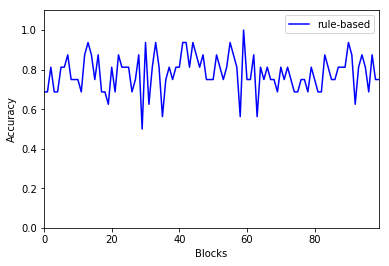

In [22]:
plt.plot(blocks_rb, 'b', label='rule-based')

plt.xlabel('Blocks')
plt.ylabel('Accuracy')

plt.axis([0, n_blocks - 1, 0, 1.1])
plt.legend()

plt.show()